# Model Development

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam

import pickle

Using TensorFlow backend.


In [2]:
df = df = pd.read_csv(project_path + '/data/raw/data.csv', index_col=0)
df.sort_values('time', inplace=True)
# Kept time because we will know the times at which we want predictions for - no problem with knowing the future.
df.drop(['index', 'volumeto'], axis=1, inplace=True)
df = df[['volumefrom','open','high','close','low','time']]
df.head()

,volumefrom,open,high,close,low,time
44022,0.00,73.7,73.7,73.7,73.7,1364086800
44023,0.00,73.7,73.7,73.7,73.7,1364090400
44024,0.00,73.7,73.7,73.7,73.7,1364094000
44025,7.42,73.7,73.7,68.2,68.2,1364097600
44026,0.00,68.2,68.2,68.2,68.2,1364101200


In [3]:
TRAIN_DATA_START_HOUR_INDEX = 10000
N_FEATURES = len(df.columns)
INPUT_HOURS = 24
PREDICT_HOURS = 6


In [4]:
"""
Cut off first ### hours from data set. The OHCLV data is much different in Bitcoin's earlier days. 
Getting rid of this data will hopefully improve the model.
"""
sample = df.iloc[TRAIN_DATA_START_HOUR_INDEX:,:]
sample.shape

(36023, 6)

In [5]:
"""
Ripped from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Using this function to format the learning problem. We give it the number of previous hours we want to use
to predict as well as the number of hours we want to predict.
""" 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [19]:
X = series_to_supervised(data=sample, n_in=INPUT_HOURS, n_out=PREDICT_HOURS)


X.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),...,var3(t+4),var4(t+4),var5(t+4),var6(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var6(t+5)
34036,77.68,442.42,442.42,441.23,440.95,1.400072e+09,95.43,441.23,441.23,440.72,...,448.59,448.59,447.55,1.400170e+09,70.44,448.59,448.79,448.41,448.06,1.400173e+09
34037,95.43,441.23,441.23,440.72,439.58,1.400076e+09,56.48,440.72,443.21,442.55,...,448.79,448.41,448.06,1.400173e+09,168.69,448.41,448.95,447.69,447.58,1.400177e+09
34038,56.48,440.72,443.21,442.55,440.37,1.400080e+09,125.23,442.55,442.97,442.58,...,448.95,447.69,447.58,1.400177e+09,83.92,447.69,447.92,446.61,446.54,1.400180e+09
34039,125.23,442.55,442.97,442.58,442.06,1.400083e+09,118.99,442.58,442.84,442.76,...,447.92,446.61,446.54,1.400180e+09,150.88,446.61,447.65,447.60,446.44,1.400184e+09
34040,118.99,442.58,442.84,442.76,441.80,1.400087e+09,118.99,442.58,442.84,442.76,...,447.65,447.60,446.44,1.400184e+09,115.31,447.60,447.66,447.54,446.45,1.400188e+09


In [20]:
Y = series_to_supervised(data=list(sample['close']), n_in=INPUT_HOURS, n_out=PREDICT_HOURS)
Y.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
24,441.23,440.72,442.55,442.58,442.76,442.76,442.94,443.43,443.41,443.94,...,447.19,449.08,448.21,448.27,447.84,448.28,449.03,448.26,448.59,448.41
25,440.72,442.55,442.58,442.76,442.76,442.94,443.43,443.41,443.94,444.26,...,449.08,448.21,448.27,447.84,448.28,449.03,448.26,448.59,448.41,447.69
26,442.55,442.58,442.76,442.76,442.94,443.43,443.41,443.94,444.26,442.63,...,448.21,448.27,447.84,448.28,449.03,448.26,448.59,448.41,447.69,446.61
27,442.58,442.76,442.76,442.94,443.43,443.41,443.94,444.26,442.63,442.17,...,448.27,447.84,448.28,449.03,448.26,448.59,448.41,447.69,446.61,447.60
28,442.76,442.76,442.94,443.43,443.41,443.94,444.26,442.63,442.17,444.68,...,447.84,448.28,449.03,448.26,448.59,448.41,447.69,446.61,447.60,447.54


# train dev split

In [21]:
"""
Train dev split. (80/20) rule is kind of over. Taking the dev set from the end of the data set because 
that data is closest in distribution to our current testing scenario (getting real time predictions). Note: I call
the dev set the 'test' set in the variable names, but it's really a dev set.
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=False)
"""
Now trim the feature values from the outcome matrix and the outcome values from the feature matrix
"""
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-PREDICT_HOURS:]
Y_test = Y_test.iloc[:,-PREDICT_HOURS:]
X_train = X_train.iloc[:,:-(PREDICT_HOURS*N_FEATURES)]
X_test = X_test.iloc[:,:-(PREDICT_HOURS*N_FEATURES)]


In [31]:
"""
Check that dates make sense
"""
pd.to_datetime(X_test["var6(t-1)"], unit='s').describe(), pd.to_datetime(X_train["var6(t-1)"], unit='s').describe()

(count                    1800
 unique                   1800
 top       2018-05-15 17:00:00
 freq                        1
 first     2018-04-08 12:00:00
 last      2018-06-22 11:00:00
 Name: var6(t-1), dtype: object, count                   34194
 unique                  34177
 top       2018-01-07 01:00:00
 freq                        2
 first     2014-05-15 11:00:00
 last      2018-04-08 11:00:00
 Name: var6(t-1), dtype: object)

In [32]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

# RNN preprocessing

In [33]:
"""
Scale the data for the RNN. Very important otherwise convergence would take a milenia.
"""
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
"""
Have to reshape the model into a 3D array to fit the RNN Model.
"""
def shape_model_data(data, n_features):
    model_data = data.reshape((data.shape[0], INPUT_HOURS, n_features))
    return model_data
X_train_3D = shape_model_data(X_train_scaled, N_FEATURES)
X_test_3D = shape_model_data(X_test_scaled, N_FEATURES)
X_train_3D[0,:,:]

array([[9.21847458e-06, 1.41361865e-02, 1.34308721e-02, 1.40755337e-02,
        1.44629940e-02, 0.00000000e+00],
       [1.13289067e-05, 1.40755337e-02, 1.33704436e-02, 1.40495396e-02,
        1.43928573e-02, 0.00000000e+00],
       [6.69784577e-06, 1.40495396e-02, 1.34709885e-02, 1.41428124e-02,
        1.44333011e-02, 0.00000000e+00],
       [1.48720547e-05, 1.41428124e-02, 1.34588012e-02, 1.41443415e-02,
        1.45198200e-02, 0.00000000e+00],
       [1.41301338e-05, 1.41443415e-02, 1.34521998e-02, 1.41535159e-02,
        1.45065094e-02, 0.00000000e+00],
       [1.41301338e-05, 1.41443415e-02, 1.34521998e-02, 1.41535159e-02,
        1.45065094e-02, 0.00000000e+00],
       [6.97725510e-06, 1.41535159e-02, 1.34846991e-02, 1.41626903e-02,
        1.45433695e-02, 0.00000000e+00],
       [7.31016834e-06, 1.41626903e-02, 1.34821601e-02, 1.41876649e-02,
        1.45561682e-02, 0.00000000e+00],
       [7.64902645e-06, 1.41876649e-02, 1.34877460e-02, 1.41866456e-02,
        1.45730624e-02, 

In [35]:
"""
Define the LSTM RNN model. I went simple here because I don't have the time to create a great model. This model
(spoiler alert!) ends up performing pretty badly. I think it would do better with a few more Dense layers, more 
training iterations, transfer learning from other coins, and with a bit of paramater tuning (random search style).
I also think that the RNN would help a lot more for drawing inferences from unstructured text data (like twitter, 
4chan, etc.). Ultimately, at the hourly level I think that an RNN would win the game. But that is not demonstrated 
here. Also initialization should be played with more here.
"""

def lstm_model(input_shape, num_outputs):
    model = Sequential()
    
    model.add(LSTM(64, input_shape=input_shape, activation='linear', return_sequences=True))
    
    model.add(Dropout(rate=0.1))
    
    model.add(LSTM(64, activation='linear'))
    
    model.add(Dense(num_outputs, activation='linear'))
    
    return model


In [36]:
rnn_model = lstm_model(X_train_3D.shape[1:], PREDICT_HOURS)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 24, 64)            18176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 51,590
Trainable params: 51,590
Non-trainable params: 0
_________________________________________________________________


In [37]:
N_EPOCHS = 20
BATCH_SIZE = 128

In [38]:
"""
Compile and fit model.
"""
rnn_model.compile(loss='mae', optimizer=Adam(lr=0.0001))

fit = rnn_model.fit(X_train_3D, Y_train, 
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_3D, Y_test))


Train on 34194 samples, validate on 1800 samples
Epoch 1/20
34194/34194 [==============================] - 35s 1ms/step - loss: 1169.1782 - val_loss: 703.3348
Epoch 2/20
34194/34194 [==============================] - 35s 1ms/step - loss: 379.2997 - val_loss: 1240.4613
Epoch 3/20
34194/34194 [==============================] - 80s 2ms/step - loss: 464.4140 - val_loss: 1226.1265
Epoch 4/20
34194/34194 [==============================] - 54s 2ms/step - loss: 337.8345 - val_loss: 748.7857
Epoch 5/20
34194/34194 [==============================] - 44s 1ms/step - loss: 333.1474 - val_loss: 765.5118
Epoch 6/20
34194/34194 [==============================] - 40s 1ms/step - loss: 317.1942 - val_loss: 749.8591
Epoch 7/20
34194/34194 [==============================] - 41s 1ms/step - loss: 304.8282 - val_loss: 761.0215
Epoch 8/20
34194/34194 [==============================] - 45s 1ms/step - loss: 300.3420 - val_loss: 1027.0812
Epoch 9/20
34194/34194 [==============================] - 43s 1ms/step - lo

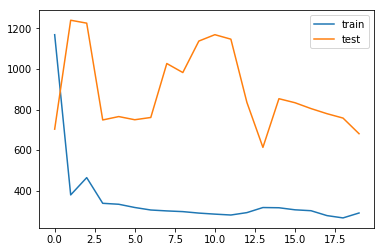

In [39]:
"""
Check out loss from train and dev sets
"""
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.legend()

## Look at some predictions

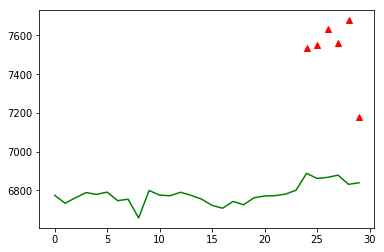

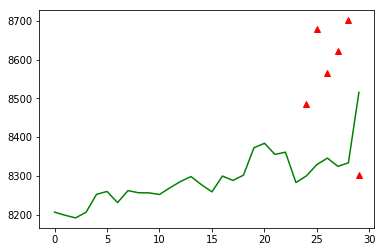

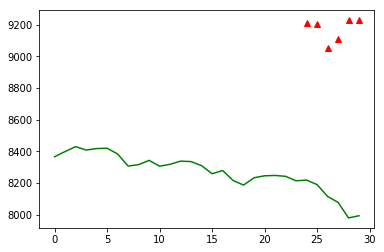

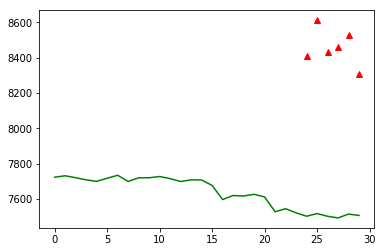

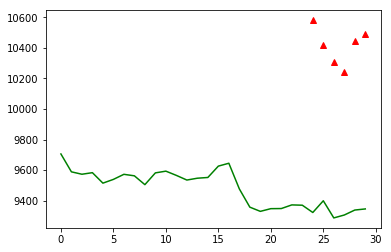

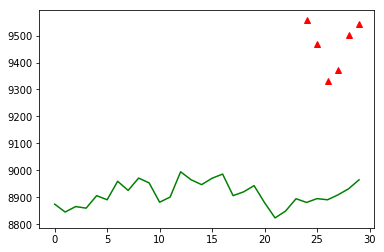

In [40]:

for ix in np.random.randint(0,Y_test_cache.shape[0],6):
    plt.figure()
    s = X_test_3D[ix,:,:]
    predict = fit.model.predict(s.reshape(1, s.shape[0], s.shape[1])).reshape(6)
    actual = Y_test_cache.iloc[ix]
    plt.plot(range(24,30), predict, 'r^', range(30), actual, 'g-')

In [45]:
# Save model
fit.model.save(project_path + '/models/lstm_model_btc.pkl')

# Let's try a simple linear regression model

In [46]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, Y_train)



In [47]:
lr_model.score(X_test, Y_test)

0.9883297760446644

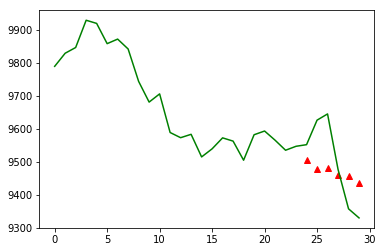

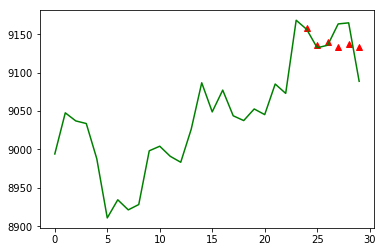

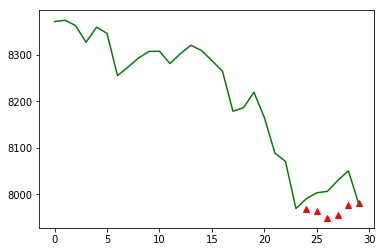

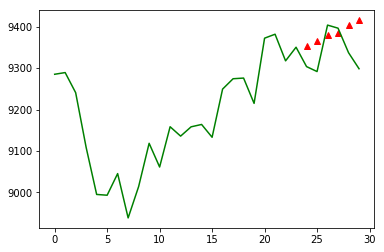

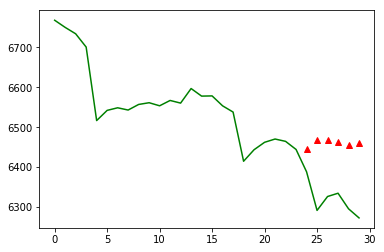

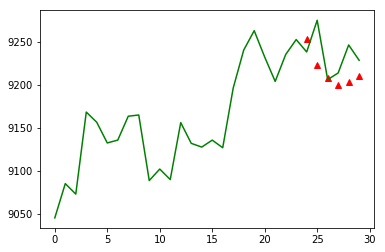

In [48]:
lr_predict = lr_model.predict(X_test)
for ix in np.random.randint(0,Y_test_cache.shape[0],6):
    plt.figure()
    
    actual = Y_test_cache.iloc[ix]
    plt.plot(range(24,30), lr_predict[ix], 'r^', range(30), actual, 'g-')

In [49]:
# Save model
with open(project_path + '/models/linear_model_btc.pkl', 'wb') as output_file:
    s = pickle.dump(lr_model, output_file)


## Much better! Makes a lot more sense.